
# TensorFlow Object Detection: Подготовка данных для обучения

https://github.com/tensorflow/models/tree/master/research/object_detection


In [ ]:
# ! pip install tf_slim
# ! pip install tf-models-official
# ! pip install lvis

### Монтирование Google Drive
Для данного демо нам понадобятся несколько ноутбуков, которые должны работать с одними и теме же данными. Поэтому, чтобы все ноутбуки имели доступ к нужным данным, нам будет необходимо подключить диск Google Drive и сохранять все данные на нём (включая данные, скачанные из интернета).

Для монтирования диска нужно выполнить данный блок, перейти по ссылке, получить код, скопировать его в поле ниже (в этом блоке) и нажать Enter

После монтирования диск будет находиться здесь: `/content/drive/My Drive`

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Рабочая директория
Все данные будем хранить в директории `/content/drive/My Drive/tf_od_demo` (TensorFlow Object Detection Demo)

При первом запуске создадим директорию (если её еще не существует), в противном случае надо заменить True на False.

При последующих подключениях к диску (в том числе в других ноутбуках) директорию создавать не надо, в ней уже будут сохранены все данные, которые мы туда поместили.

In [5]:
if False:
    !mkdir "/content/drive/My Drive/tf_single"
%cd "/content/drive/My Drive/tf_single"

/content/drive/My Drive/tf_single


### Подготовка библиотеки `object_detection`
Библиотека `object_detection` находится в репозитории `tensorflow/models` в разделе `research`

Необходимо склонировать код библиотеки и сконфигурировать модели (сбилдить прото модели).

Этот шаг нужно сделать один раз (не повторять, если папка `models` уже находится в текущей директории).

Подробнее: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md

In [6]:
!git clone https://github.com/tensorflow/models
!cd models/research && protoc object_detection/protos/*.proto --python_out=.
!cd models/research && export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim && python object_detection/builders/model_builder_test.py

fatal: destination path 'models' already exists and is not an empty directory.
2021-05-04 17:08:41.250261: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### Загрузка библиотек
Загрузка TensorFlow и других библиотек. Кроме того, загрузка модуля `dataset_util` из пакета `object_detection`, который будет нужен для создания датасета в нужном формате.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import os
from PIL import Image

%tensorflow_version 1.x
import tensorflow as tf

import sys
sys.path.insert(0, 'models/research')

print(tf.__version__)

from object_detection.utils import dataset_util

TensorFlow 1.x selected.
1.15.2


### Функция для создания одного обучающего образца
В этой функции создаётся экземпляр класса `tf.train.Example`, который соответствует одной обучающей картике. Ей могут соответствовать несколько ground-truth баундинг боксов. Однако, конкретно в данном примере на картинке есть строго один бокс. В противном случае списки `xmins`, `xmaxs`, `ymins`, `ymaxs`, `classes_text`, `classes` должны иметь соответствующее количество элементов ( = кол-ву боксов на данной картинке).

Создавать экземпляры класса `tf.train.Example` можно произвольным способом. В данном примере на вход в функцию подаётся строка из CSV файла (`annot.csv`). Главное -- заполнить соовтестсвующие поля словаре `feature={...}`

Подробнее: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md

In [8]:
def create_tf_example(example):
  
    img_fpath = os.path.join('my_data', example.id)
    img = Image.open(img_fpath)
    height = img.size[1]
    width = img.size[0]
    filename = str.encode(example.id)
    with open(img_fpath, mode='rb') as f:
        encoded_image_data = f.read()
    image_format = b'jpeg'

    # List of normalized left x coordinates in bounding box (1 per box)
    xmins = [example.xmin / float(width)] 
    # List of normalized right x coordinates in bounding box # (1 per box)
    xmaxs = [example.xmax / float(width)] 
    # List of normalized top y coordinates in bounding box (1 per box)
    ymins = [example.ymin / float(height)] 
    # List of normalized bottom y coordinates in bounding box # (1 per box)
    ymaxs = [example.ymax / float(height)] 
    # List of string class name of bounding box (1 per box)
    classes_text = [b'Joystick']
    # List of integer class id of bounding box (1 per box)
    classes = [1]

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

### Чтение CSV файла с разметкой
В данном файле представлена разметка обучающих изображений. Сам файл и его формат показаны лишь для примера, они никак не связаны с библиотекой `object_detection`. Наша финальная цель -- создать датасет в формате `TFRecord`, состоящий из экземпляров `tf.train.Example`.

---

В данном примере формат файла annot.csv следующий (один бокс на файл):

id,xmin,ymin,xmax,ymax

1.jpg,261,260,601,615

2.jpg,130,429,401,734

...

---

Перед запуском этого блока загрузите необходимые данные (папка `my_data`) в текущую рабочую директорию (tf_od_demo). Один из вариантов, как это можно сделать, это загрузить архив `my_data.7z`, а затем разархивировать его с помощью команды:

`!7z x my_data.7z`

In [10]:
!7z x my_data.7z

In [9]:
annot = pd.read_csv('my_data/annot.csv')
annot.head()

,id,xmin,ymin,xmax,ymax
0,1.jpg,68,264,426,496
1,2.jpg,75,259,469,594
2,3.jpg,77,249,412,666
3,4.jpg,59,314,409,626
4,5.jpg,56,252,407,754


### Создание TFRecord
Здесь мы создаём финальный датасет в формате `TFRecord`, который необходим для запуска обучения TF Object Detection. 

В цикле по всем обучающим образцам создаем `TF Example` и записываем его в `TF Record`.

In [10]:
writer = tf.io.TFRecordWriter('my_data/train_data.record')

for idx, row in annot.iterrows():
    tf_example = create_tf_example(row)
    writer.write(tf_example.SerializeToString())

writer.close()


# TensorFlow Object Detection: Обучение модели

https://github.com/tensorflow/models/tree/master/research/object_detection

### Загрузка предобученной модели
Во время обучения мы будем делать fine-tuning предобученной модели. Для этого необходимо загрузить веса соответствующей модели `ssd_mobilenet_v1_coco`. Из названия следует, что детекционная архитектура -- `SSD`, базовая CNN модель -- `MobileNet_v1`, предобучена на датасете COCO.

Этот шаг нужно сделать один раз (не повторять, если модель уже была скачана ранее).

In [11]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
!tar -xzf ssd_mobilenet_v1_coco_2018_01_28.tar.gz

### Подготовка данных для обучения
Ранее мы подготовили файл `train_data.record`, в котором содержится обучающий датасет.
Кроме него для обучения необходимо подготовить еще два файла (они также находятся в папке `my_data`)

* `label_map.pbtxt` (в нашем случае `cube_label_map.pbtxt`) - файл с описанием классов. В нашем случае у нас всего один класс.

* `pipeline.config` - файл, содержищий различне гиперпарамтеры и настройки обучения. Важные параметры: `num_classes`, `fine_tune_checkpoint`, `label_map_path`, `input_path`. В данном примере и для обучения и для теста используется один и тот же датасет (см. блоки параметров `train_input_reader`, `eval_input_reader`)

### Запуск обучения
После того, как мы подготовили все данные, запустить обучение очень просто: надо просто запустить скрипт `model_main.py` и передать ему соответствующие параметры.

*   Путь к файлу `pipeline.config`
*   Директорию, для записи выхода обучения (`model_dir`)
*   Количество итераций обучения (`num_train_steps`)


In [12]:
%%time

if True:
    # Delete output directory
    !rm -rf my_data/output

!export PYTHONPATH=$PYTHONPATH:models/research:models/research/slim ; python models/research/object_detection/model_main.py \
    --pipeline_config_path=my_data/pipeline.config \
    --model_dir=my_data/output \
    --num_train_steps=10000 \
    --alsologtostderr

W0504 17:10:40.989913 139855394387840 model_lib.py:812] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 10000
I0504 17:10:40.990182 139855394387840 config_util.py:552] Maybe overwriting train_steps: 10000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0504 17:10:40.990284 139855394387840 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0504 17:10:40.990369 139855394387840 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0504 17:10:40.990449 139855394387840 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0504 17:10:40.990564 139855394387840 model_lib.py:828] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to

### Заморозка модели
Для того, чтобы использовать обученную модель в режиме инференса, её нужно "заморозить". Другими словами - подготовить к инференсу. Для этого надо запустить скрипт `export_inference_graph.py` и передать соответствующие парамтеры.

* Путь к файлу `pipeline.config`
* Путь к весам обученной модели (`trained_checkpoint_prefix`)
* Путь к директории для сохранения замороженной модели (`output_directory`)

In [15]:
!export PYTHONPATH=$PYTHONPATH:models/research:models/research/slim ; python models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=my_data/pipeline.config \
    --trained_checkpoint_prefix=my_data/output/model.ckpt-10000 \
    --output_directory=my_data/output/frozen/

Instructions for updating:
Please use `layer.__call__` method instead.
W0504 17:28:08.783834 140277011195776 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0504 17:28:10.187051 140277011195776 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0504 17:28:10.223000 140277011195776 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0504 17:28:10.256595 140277011195776 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

# TensorFlow Object Detection: Тестирование модели

https://github.com/tensorflow/models/tree/master/research/object_detection

### Загрузка библиотек
Загрузка TensorFlow и других библиотек. # TensorFlow Object Detection: Тестирование модели

https://github.com/tensorflow/models/tree/master/research/object_detectionКроме того, загрузка различных модулей из пакета `object_detection`.

In [14]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

### Загрузка соответствия имён классов и их ID

In [16]:
PATH_TO_LABELS = 'my_data/joystick_label_map.pbtxt'

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### Загрузка замороженного графа для инференса

In [17]:
PATH_TO_FROZEN_GRAPH = 'my_data/output/frozen/frozen_inference_graph.pb'

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### Функция для детектирования объектов на одном изображении

In [18]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: image})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[ 'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

### Запуск детектрования объектов

In [25]:
image_np = imageio.imread('my_data/test.jpg')
image_np_expanded = np.expand_dims(image_np, axis=0)

output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)

### Визуализация результатов детектирования
Визуализируем получившиеся детекции. Здесь их можно дополнительно отфильтровать по скору, используя `min_score_thresh`

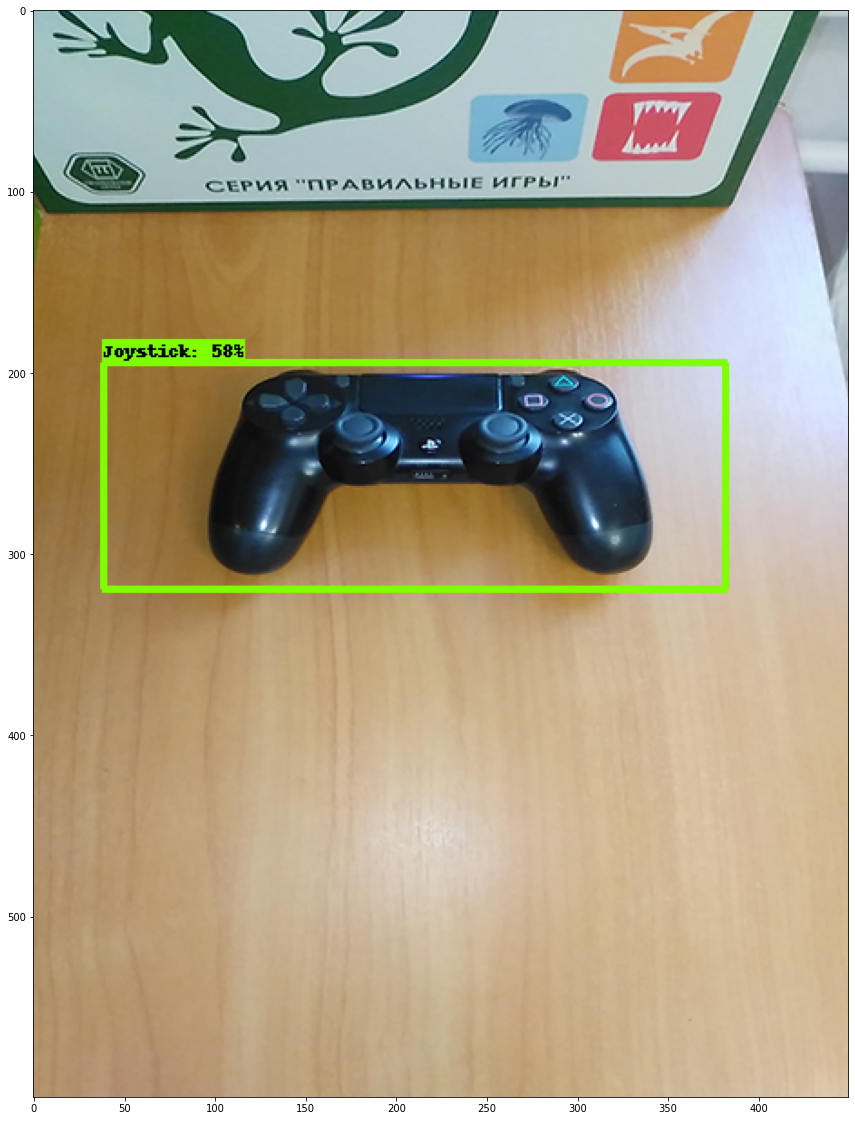

In [27]:
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=4,
    min_score_thresh=0.5)

%matplotlib inline
plt.figure(figsize=(20,20))
plt.imshow(image_np)
plt.show()